In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import sys
sys.path.append('..')
from lib import *

plt.style.use('../peptidome.mplstyle')

In [3]:
L = 9
params = np.load('data/Human_reference_9.npz')
hi = params['hi']
Jij = params['Jij']

In [67]:
datasets = ['train', 'test', 'model', 'model_ncov', 'model_nskew', 'model_nskewdiag']
sample_matrices = {}
for dataset in datasets:
    sample_matrices[dataset] = load_matrix('data/%s_matrix_L%i.csv.gz' % (dataset, L))

In [19]:
observables = ['fi', 'fij', 'cij', 'fijk', 'cijk', 'fold_ijk']#, 'fijkl']
observables_dict = {key: dict() for key in observables}
for dataset in ['train', 'test', 'model']:
    params = np.load('data/%s_observables.npz'%dataset)
    for observable in observables:
        observables_dict[observable][dataset] = params[observable]

In [11]:
fi = observables_dict['fi']['train'].mean(axis=0)
sample_independent = np.random.choice(np.arange(0, 20, 1), size=sample_matrices['test'].shape, p=fi)

In [6]:
arr = np.load('../aafreqpca/data/data.npz')
aa_human = arr['human']

In [7]:
cov = np.cov(aa_human.T)
alpha = np.mean(aa_human, axis=0)
alpha0 = alpha*(1-alpha)/np.diag(cov) - 1.0
alpha0

array([103.97144572,  52.27539978, 173.05226162,  84.67300122,
       140.7069723 ,  92.61090593, 172.27398996, 116.7177847 ,
        78.21749722, 112.76767947, 235.91539032, 169.00405327,
        67.41864509, 145.6206498 , 118.92310653, 114.44634793,
       191.08027332, 178.04419657, 198.44854756, 169.26510308])

(array([  16.,  107.,  521., 1521., 2914., 3777., 3639., 3001., 1962.,
        1148.,  665.,  320.,  186.,   85.,   63.,   52.,   19.,   14.,
          21.,   10.,    5.,    7.,    5.,    6.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24]),
 <a list of 1 Patch objects>)

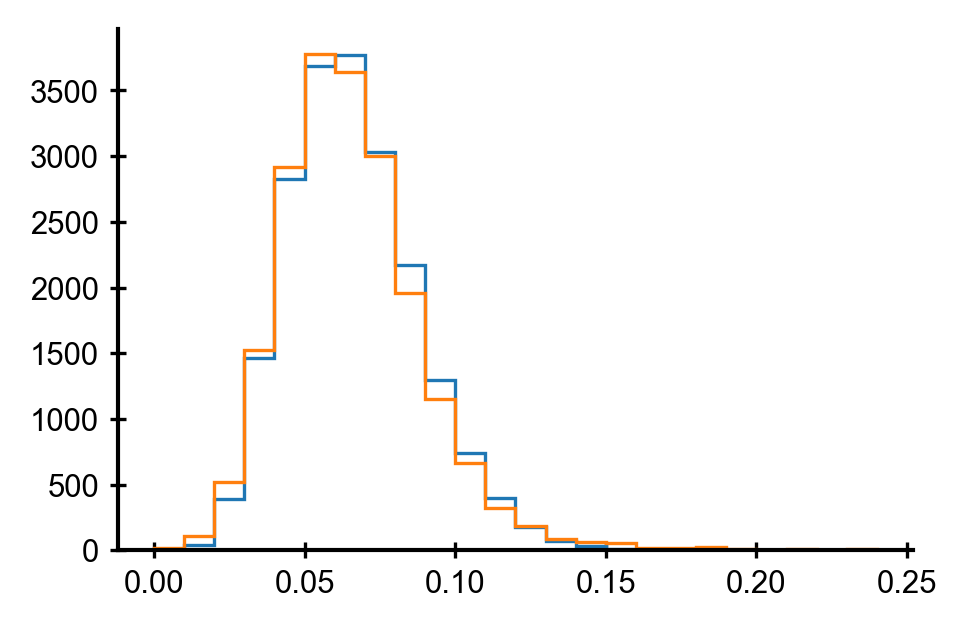

In [8]:
p = np.random.dirichlet(alpha*np.mean(alpha0), size=aa_human.shape[0])
bins = np.arange(0, 0.25, 0.01)
plt.hist(p[:, 5], bins=bins, histtype='step')
plt.hist(aa_human[:, 5], bins=bins, histtype='step')

In [9]:
sampless = []
ps = np.random.dirichlet(alpha*np.mean(alpha0), size=aa_human.shape[0]//2)
blocklength = sample_matrices['test'].shape[0]//len(ps)
for p in ps:
    samples = np.random.choice(np.arange(0, 20, 1),
                               size=(blocklength, sample_matrices['test'].shape[1]),
                               p=p)
    sampless.append(samples)
sample_dirichlet = np.concatenate(sampless)

In [10]:
sampless = []
ps = aa_human
blocklength = sample_matrices['test'].shape[0]//len(ps)
for p in ps:
    samples = np.random.choice(np.arange(0, 20, 1),
                               size=(blocklength, sample_matrices['test'].shape[1]),
                               p=p)
    sampless.append(samples)
sample_composition = np.concatenate(sampless)

In [113]:
@njit
def energy(x):
    return energy_potts(x, hi, Jij)

In [115]:
energies = {}
for dataset in ['test', 'model', 'model_ncov', 'model_nskew', 'model_nskewdiag']:
    energies[dataset] = np.array([energy(x) for x in sample_matrices[dataset]])
energies['independent'] = np.array([energy(x) for x in sample_independent])

In [116]:
len(energies['test']), len(energies['model']), len(energies['model_ncov'])

(5367489, 5421764, 5421764)

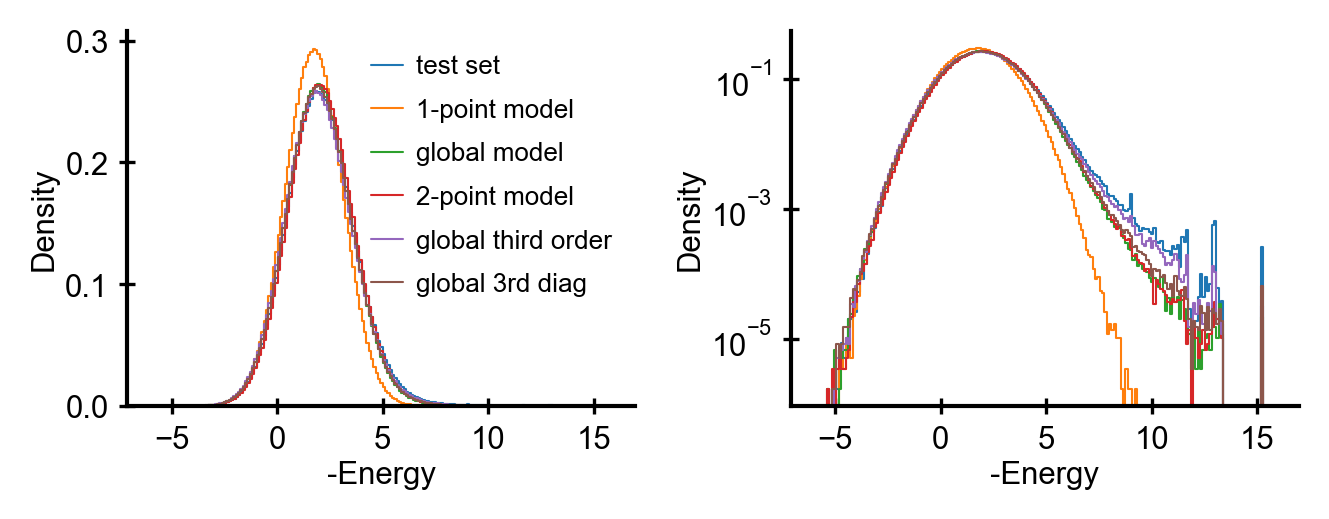

In [117]:
bins = np.linspace(-6, 16, 100)
fig, axes = plt.subplots(figsize=(4.5, 1.8), ncols=2)
#for dataset in ['test', 'independent', 'model', 'cov', 'third']:
labels = {'test': 'test set',
          'model': '2-point model',
          'model_ncov':'global model',
          'independent' : '1-point model',
          'model_nskew': 'global third order',
          'model_nskewdiag': 'global 3rd diag'}
datasets = ['test', 'independent', 'model_ncov', 'model', 'model_nskew', 'model_nskewdiag']
xmax = 16
xmin = -6
nbins = 200
for ax in axes:
    plot_histograms([-energies[dataset] for dataset in datasets],
                    [labels[dataset] for dataset in datasets],
                    step=True, nbins=nbins, xmin=xmin, xmax=xmax, lw=0.5, ax=ax, scaley=nbins/(xmax-xmin))
    ax.set_xlabel('-Energy')
    ax.set_ylabel('Density')
axes[0].set_ylim(0.0)
#for dataset in datasets:
#    ax.hist(-energies[dataset], bins=bins, histtype='step', label=labels[dataset], density=True)
axes[0].legend(fontsize='x-small')
axes[1].get_legend().remove()
axes[1].set_yscale('log')
fig.tight_layout()
fig.savefig('density_of_states.png')
fig.savefig('../../paper/images/dos.pdf')

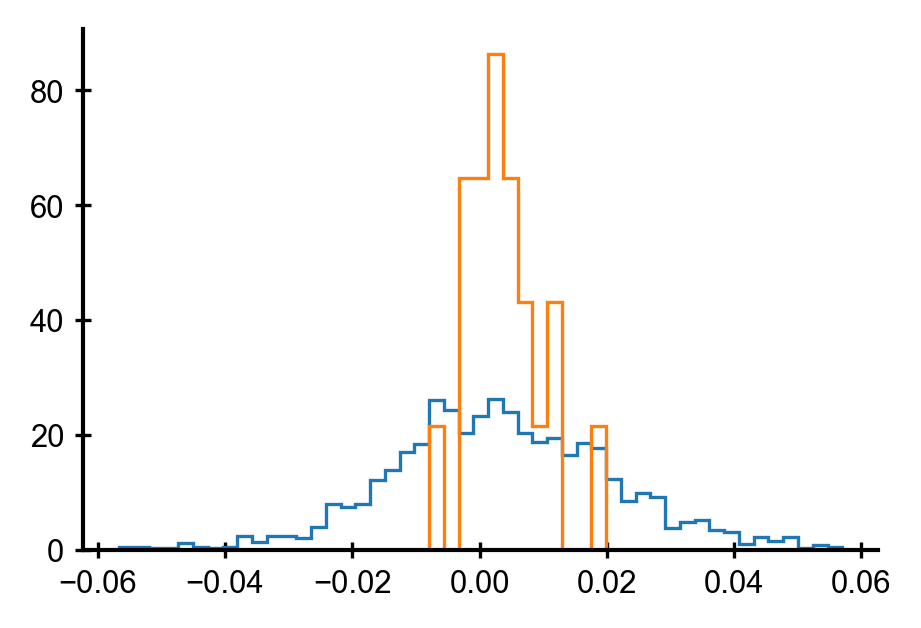

In [107]:
J2 = np.load('data/Human_nskew_9.npz')['J2']
J2diag = [J2[alpha, alpha, alpha] for alpha in range(naminoacids)]
bins = np.linspace(np.amin(J2), np.amax(J2))
plt.hist(J2.flatten(), density=True, histtype='step', bins=bins)
plt.hist(J2diag, density=True, histtype='step', bins=bins);

In [111]:
list(zip(np.load('data/Human_nskewdiag_9.npz')['J2'], J2diag))

[(0.005528579350366695, 0.006989415527834285),
 (-0.000490488510589386, -0.007566881525718562),
 (0.004746111563919675, 0.00960861251187901),
 (0.003457890011867693, 0.005908306975252388),
 (0.00011441873709671727, -0.0021344630454764226),
 (0.006017145887626679, 0.006978661140310664),
 (0.013773023874094438, 0.01936753975114878),
 (-0.001436246058026596, -0.0022720288923674136),
 (0.0008751561144371233, 0.002550564223574996),
 (0.002105243600159295, 0.0034507075171602785),
 (0.0037598803093053575, 0.0010071808361185397),
 (0.00045871615905420196, -0.0007060915746779927),
 (0.0018890560215912796, 0.001530306691775807),
 (0.009619951255021778, 0.0121945972209229),
 (0.0007462292826030457, 0.0015228379066869859),
 (0.0035611366550557582, 0.005001476133051156),
 (0.00749708308767569, 0.01265655979448924),
 (-0.00010223717932330546, -0.0008469126802771246),
 (0.008270760354473253, 0.004324884805089397),
 (0.0005611679924984609, -0.0026048652136603737)]

In [112]:
[''.join(row) for row in map_numbertoaa(sample_matrices['test'][energies['test'] < -10])]

['PSLSSSSSS',
 'SLSSSSSSS',
 'LSSSSSSSS',
 'SSSSSSSSS',
 'SSSSSSSSN',
 'SSSSSSSAS',
 'PAPGPPPPP',
 'APGPPPPPP',
 'PGPPPPPPP',
 'GPPPPPPPA',
 'PPPPPPPAP',
 'PPPPPPAPP',
 'PPPPPAPPQ',
 'QQPPPPPPP',
 'QPPPPPPPA',
 'PPPPPPPAP',
 'PPPPPPAPP',
 'PPPPPAPPP',
 'PPPPAPPPG',
 'PPPAPPPGP',
 'GAGGGGGGG',
 'AGGGGGGGG',
 'GGGGGGGGG',
 'GGGGGGGGG',
 'GGGGGGGGG',
 'GGGGGGGGG',
 'GGGGGGGGG',
 'GGGGGGGGG',
 'GGGGGGGGA',
 'GGGGGGGAG',
 'GGGGGGAGG',
 'GGGGGAGGG',
 'GGGGAGGGG',
 'GGGAGGGGG',
 'GGAGGGGGG',
 'AAAAAAAAA',
 'AAAAAAAAA',
 'AAAAAAAAA',
 'AAAAAAAAA',
 'AAAAAAAAV',
 'PPQPPPPPP',
 'PPPPPPQGP',
 'GAAAAAAAA',
 'AAAAAAAAA',
 'AAAAAAAAA',
 'AAAAAAAAA',
 'AAAAAAAAA',
 'AAAAAAAAA',
 'AAAAAAAAA',
 'AAAAAAAAA',
 'AAAAAAAAA',
 'GGGGGGAGG',
 'GGGGGAGGG',
 'PRPPPPPPP',
 'RPPPPPPPG',
 'PPPPPPPGE',
 'AAAAAAAAA',
 'AAAAAAAAA',
 'AAAAAAAAG',
 'APPPPPPGP',
 'PPPPPPGPG',
 'PPPPPGPGG',
 'PPPPGPGGP',
 'PAAAAAAAA',
 'AAAAAAAAA',
 'AAAAAAAAA',
 'AAAAAAAAA',
 'AAAAAAAAS',
 'AAAAAAASA',
 'SGSSSSSSS',
 'GSSSSSSSS',
 'SSSS

In [40]:
len([''.join(row) for row in map_numbertoaa(sample_matrices['test'][energies['test'] < -15])])

154

In [34]:
[np.mean(energies[dataset]) for dataset in datasets]

[-2.1713909870793495,
 -1.797020033252432,
 -2.0204479399259125,
 -2.1570303708287377]